# Bitcoin prediction - Artificial Intelligence Exam Summer 2019
## Time series prediction using:
* Autoregressive Integrated Moving Average (ARIMA)
* Recurrent Neural Networks and Long-Short Term Memory

Bitcoin is the largest cryptocurrency in the world. It is a digital currency without need of a central bank or administrator. It is purely based off the peer-to-peer network. Since 2013 bitcoin price has been doubled by a 1000. The price is now around 9000 USD.

In this notebook we will investigate wether it is possible to predict future Bitcoin prices based on time series data.
The dataset is from [CryptoCompare](https://www.cryptocompare.com/).



In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
from math import sqrt
import statsmodels.api as sm
from datetime import datetime
import requests
import json

# Pandas - data analysis library.
import pandas as pd
from pandas import Series

# Sklearn - supervised and unsupervised learning algorithm library.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Keras - neural-network library running on top of Tensorflow.
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import LSTM
#from keras.layers import CuDNNLSTM
#from keras.layers import RepeatVector
#from keras.layers import TimeDistributed
#from keras.layers import ConvLSTM2D
from keras.layers import Dropout

# Matplot library - interface for plotting.
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


## Loading data from the Bitcoin API

In [2]:
# Get request to the API.
# The data is from today and 2000 days in the past. The price i calculated in USD.
request = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000')
# Loading the data from the API, which is in JSON format, into a DataFrame.
hist = pd.DataFrame(json.loads(request.content)['Data'])
# Setting the index of the dataframe to the coloum 'time'.
hist = hist.set_index('time')
# Converting the time coloum from UNIX timestamp to regular time format.
hist.index = pd.to_datetime(hist.index, unit='s')
# Creating a new coloum from the mean value of close, high, low and open.
hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4
hist.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-24,7996.40,8165.45,7801.57,7876.50,51604.15,4.131627e+08,7959.9800
2019-05-25,8059.13,8140.82,7948.68,7996.40,22294.65,1.792063e+08,8036.2575
2019-05-26,8726.23,8779.00,7894.53,8059.13,57648.95,4.836637e+08,8364.7225
2019-05-27,8785.17,8931.53,8668.46,8726.23,57692.17,5.071647e+08,8777.8475
2019-05-28,8695.36,8818.71,8562.20,8785.17,36051.50,3.138563e+08,8715.3600


In [3]:
# Creating a new array containing the mean of each month
month_hist = hist['Weighted_Price'].resample('MS').mean()
month_hist.tail()
month_hist = month_hist['2016':]

In [4]:
# Checking if there is any zero values in our dataset.
print(f'NaN values: \n\n{hist.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


## Bitcoin graph

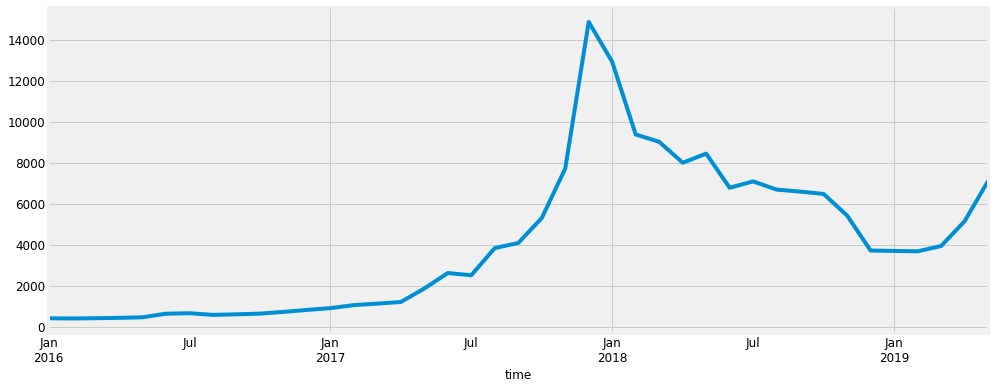

In [5]:
# Plotting the price over time i months.
month_hist.plot(figsize=(15,6))
plt.show()

---

# ARIMA prediction
ARIMA model is a statistical model for analyzing and forecasting time series data.

* Auto Regression tries to fit a line based on previous values. This is the 'p' in the ARIMA p-d-q formular. This value is setting how many months backwards we want to use to predict 1 month forward.

* Integrated making the data stationary. This is the 'd' in the ARIMA p-d-q formular. The data must be stationary in order to work with it in the SARIMA model. Stationary is, the mean variance should be constant.

* Moving Average is 



Skal vi skrive lidt tekst om hvad ARIMA er og hvad vi tager højde for i denne model?
Måske det om vi bruger seasonal?
Hvordan ser formlen ud?

desuden sagde hun der vigtigste var billede illustrationer. måske vi skal finde noget ift arima men også rnn lstm.
fx. til lstm kan vi tegne det som hun tegnede for os i dag når man forudsiger lstm

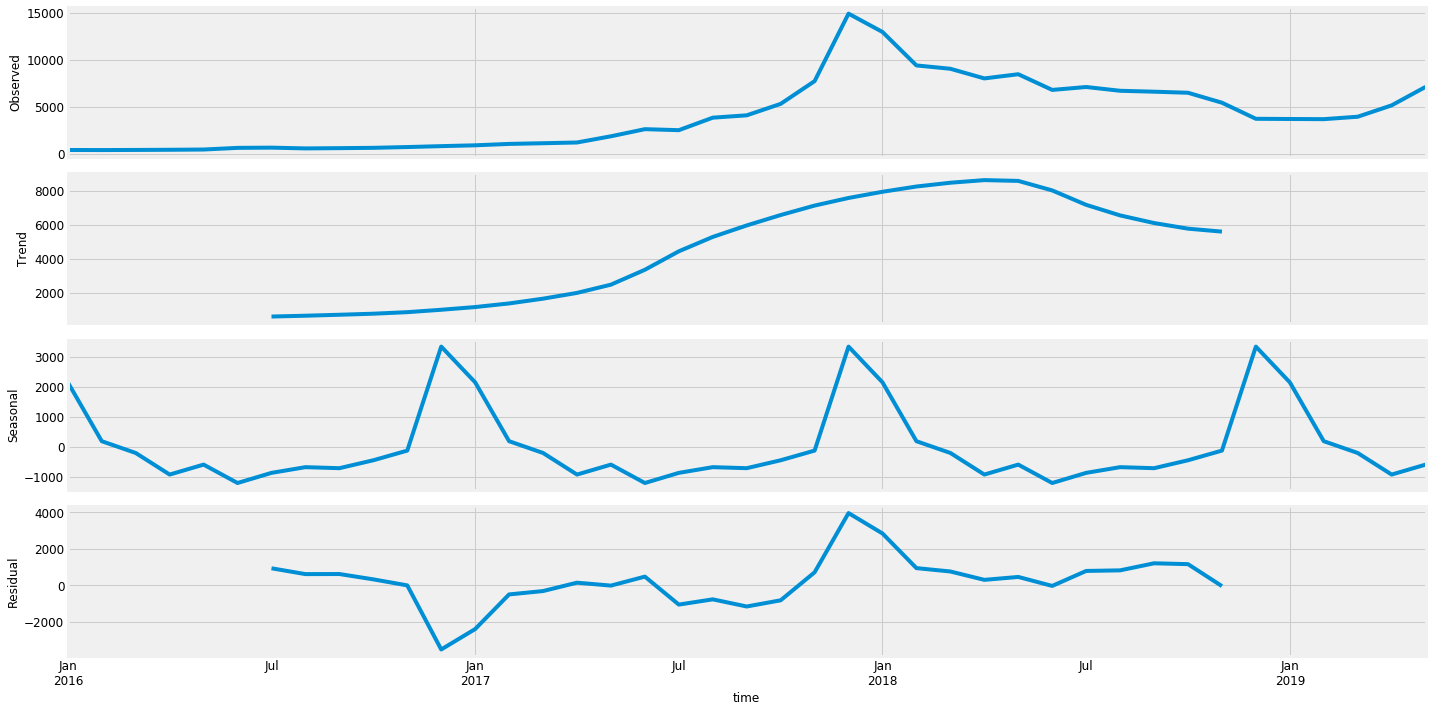

In [6]:
rcParams['figure.figsize'] = 20, 10

# Decomposing to visualize and identify trend, seasonality and residual.
# The graphs shows a opward going trend in the bitcoin market late 2016.
# There is a possible seasonality pattern at the end of the year with a big increase in price with a following decrease.
# Residual is noise. This is what there is left when removing trend and seasonal from the observed graph.
decomposition = sm.tsa.seasonal_decompose(month_hist, model='additive')
fig = decomposition.plot()
plt.show()

In [7]:
# ARIMA model (seasonal ARIMA, SARIMA)
# 'p' is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
# 'd' is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
# 'q' is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
# These are the three integers (p, d, q) that are used to parametrize ARIMA models.
p = d = q = range(0, 3)

# pdq is an array of tuples. 
# Generating 2 arrays of tuples with examples of parameter combinations bewtween (0-1).
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [162]:
# We are trying to find the combination with the lowest AIC(an estimator to realative quaility of statistical models for a given set of data).
for param in pdq:
    for param_seasonal in seasonal_pdq:
        # Try since not all combinations makes sense, some will throw an error.
        try:
            # Using Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model(SARIMAX).
            # eXogenous argument is not given, which makes it a SARIMA model.
            model = sm.tsa.statespace.SARIMAX(month_hist,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        # If we come across an invalid combination, just skip it and continue.
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:805.1859613235583
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1166.5984829767428
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:568.6390222913287
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:344.94258222386844
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:586.3326767026648
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1127.74862442779
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:346.00990373808037
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:85.52956222016002
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:338.400144574602
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:340.6613624074992
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:79.57243391487818
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:743.0162261694833
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2347.0537667152475
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:531.3515680891749
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:314.90398597743746
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:558.4156150075306
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2267.6055995980614
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:325.84269619446366
ARIMA

ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:50.62662306486215
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:248.33334920132535
ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:247.63475600429845
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:43.947713790058444
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:655.5737087107257
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:2203.839911910987
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:474.51426638761967
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:268.4469232980193
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:489.0148788481387
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:457.1166568568739
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:245.85025817448883
ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:43.48912995654646
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:247.88463026856002
ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:251.57620502947137
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:38.57142451011634
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:683.5322461800797
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:617.0294334922609
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:499.3287706724536
ARI

In [8]:
#ARIMA(4, 4, 4)x(4, 1, 1, 12)12 - AIC:96.11295809398507
#ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:17.271069152913338

model = sm.tsa.statespace.SARIMAX(month_hist,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[0])

                                 Statespace Model Results                                 
Dep. Variable:                     Weighted_Price   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.642
Date:                            Tue, 28 May 2019   AIC                            247.285
Time:                                    22:30:35   BIC                            249.409
Sample:                                01-01-2016   HQIC                           247.262
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         


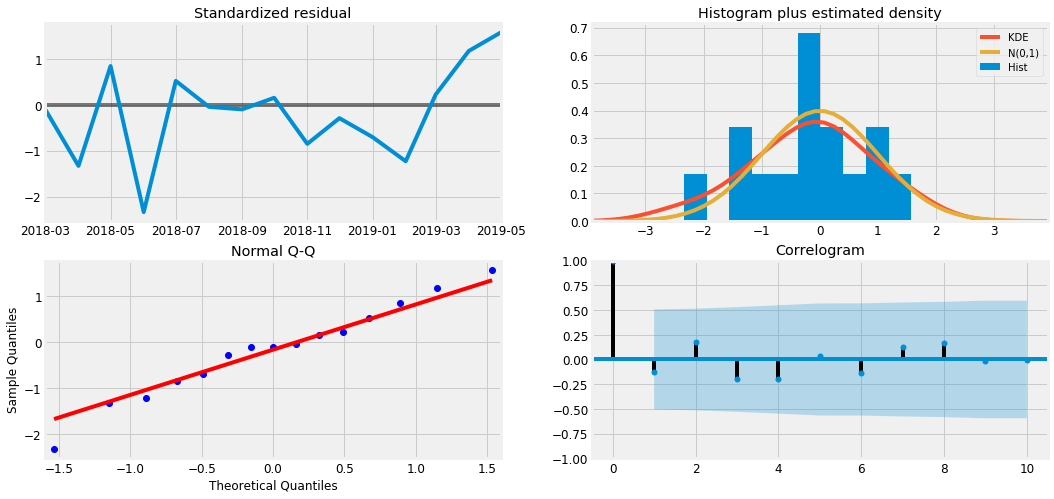

In [97]:
# Plitting model diagnostics to investigate unusual behavior.
# Residual is the difference between true and predicted value.

# Normal Quantile-Quantile is a way to visualize if the data were normally distributes. The closer to the line, the more normally distributed.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Testing the model

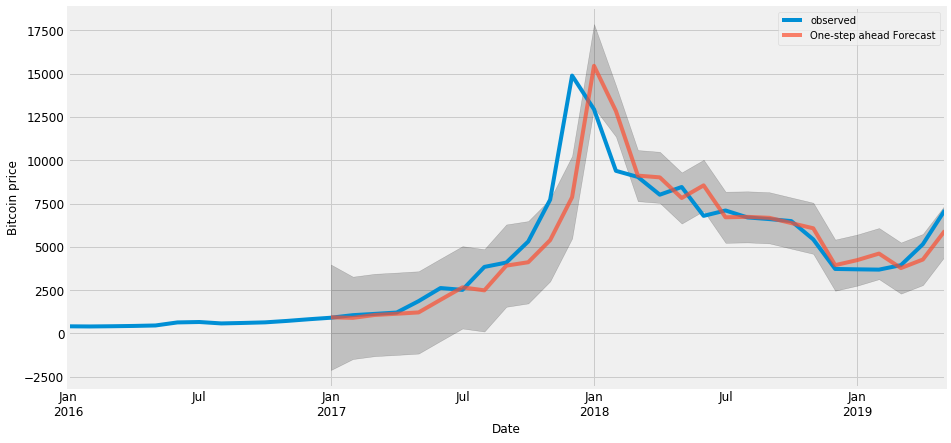

In [98]:
# Making a prediction from 1. Janurary 2017 to now, so we can compare the result with the actual observed graph.
pred = results.get_prediction(start=('2017-01-01'), dynamic=False)


# Plotting the observed graph and the 'one-step forecasting',
ax = month_hist.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [99]:
# This is the confidence interval.
# It shows the difference between lower and upper values of predicted weighted price over time.
print(pred_ci)

            lower Weighted_Price  upper Weighted_Price
time                                                  
2017-01-01          -2112.227976           3976.868832
2017-02-01          -1479.220020           3277.043361
2017-03-01          -1311.018774           3442.725765
2017-04-01          -1240.797040           3512.945388
2017-05-01          -1162.927091           3590.815329
2017-06-01           -434.112181           4319.630239
2017-07-01            284.877195           5038.619615
2017-08-01            111.233029           4864.975450
2017-09-01           1539.425163           6293.167583
2017-10-01           1734.773106           6488.515526
2017-11-01           3010.743053           7764.485342
2017-12-01           5489.890983          10243.493515
2018-01-01          13045.639185          17867.509967
2018-02-01          11366.555520          14323.289446
2018-03-01           7639.108166          10590.114084
2018-04-01           7538.950043          10489.955961
2018-05-01

In [100]:
# Calculating the mean absolute error.
y_forecasted = pred.predicted_mean
y_truth = month_hist['2017-01-01':]

# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(y_truth, y_forecasted)
print('Mean absolute error',mae)

Mean absolute error 982.5505965521312


## Future prediction

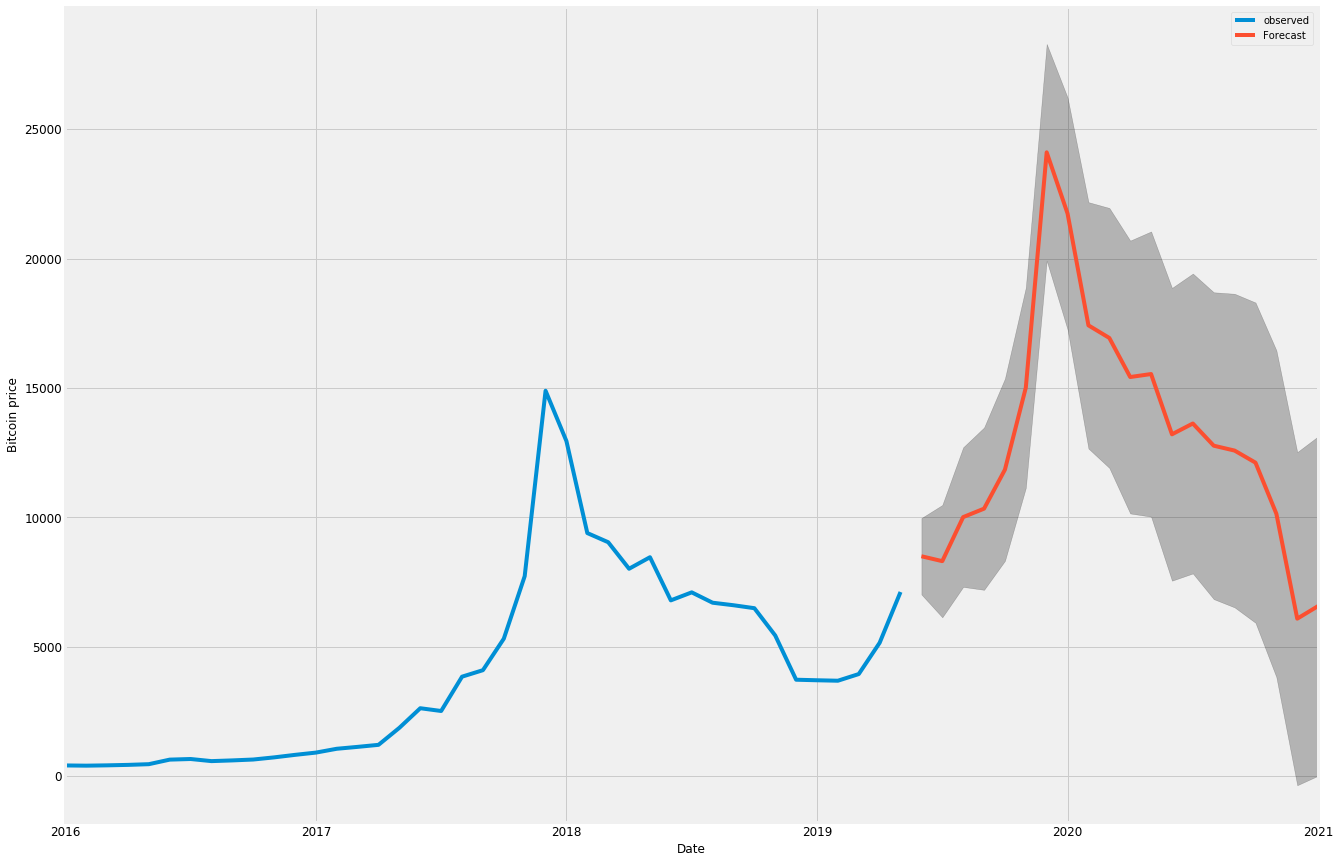

In [101]:
# We generate a forecast for the furture graph of Bitcoin.
# We call the method get_forecast which takes a parameter 'steps', as how many steps into the future do we want to forecast.
future_pred = results.get_forecast(steps=20)

# We plot the observed graph of Bitcoin prices.
ax = month_hist.plot(label='observed', figsize=(20, 15))
future_pred.predicted_mean.plot(ax=ax, label='Forecast')

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = future_pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [102]:
# Plotting the result in USD
future_pred.predicted_mean

2019-06-01     8495.990005
2019-07-01     8306.386064
2019-08-01    10008.633213
2019-09-01    10335.153855
2019-10-01    11841.104427
2019-11-01    15010.415678
2019-12-01    24106.638688
2020-01-01    21740.346861
2020-02-01    17419.479360
2020-03-01    16932.513517
2020-04-01    15422.147148
2020-05-01    15537.402204
2020-06-01    13208.392241
2020-07-01    13626.038888
2020-08-01    12768.756135
2020-09-01    12579.550780
2020-10-01    12113.201295
2020-11-01    10139.388153
2020-12-01     6083.300815
2021-01-01     6571.836884
Freq: MS, dtype: float64

## Conclusion
The model does seem to capture the trends and seasonality in the Bitcoin price. However, this also means that in the future it will predict the price to rise dramatically, like it did at some point in the training set.

---

# RNN LSTM Prediction
A **reccurent network** is networks with loops in them.
A loop allows information to be passed from on node in a network to another.
The image below illustrates a recurrent network. The loop to left is equal to the illustration of a loop on the right.
The network takes an input but also the output from the previous nodes as input to the current step.

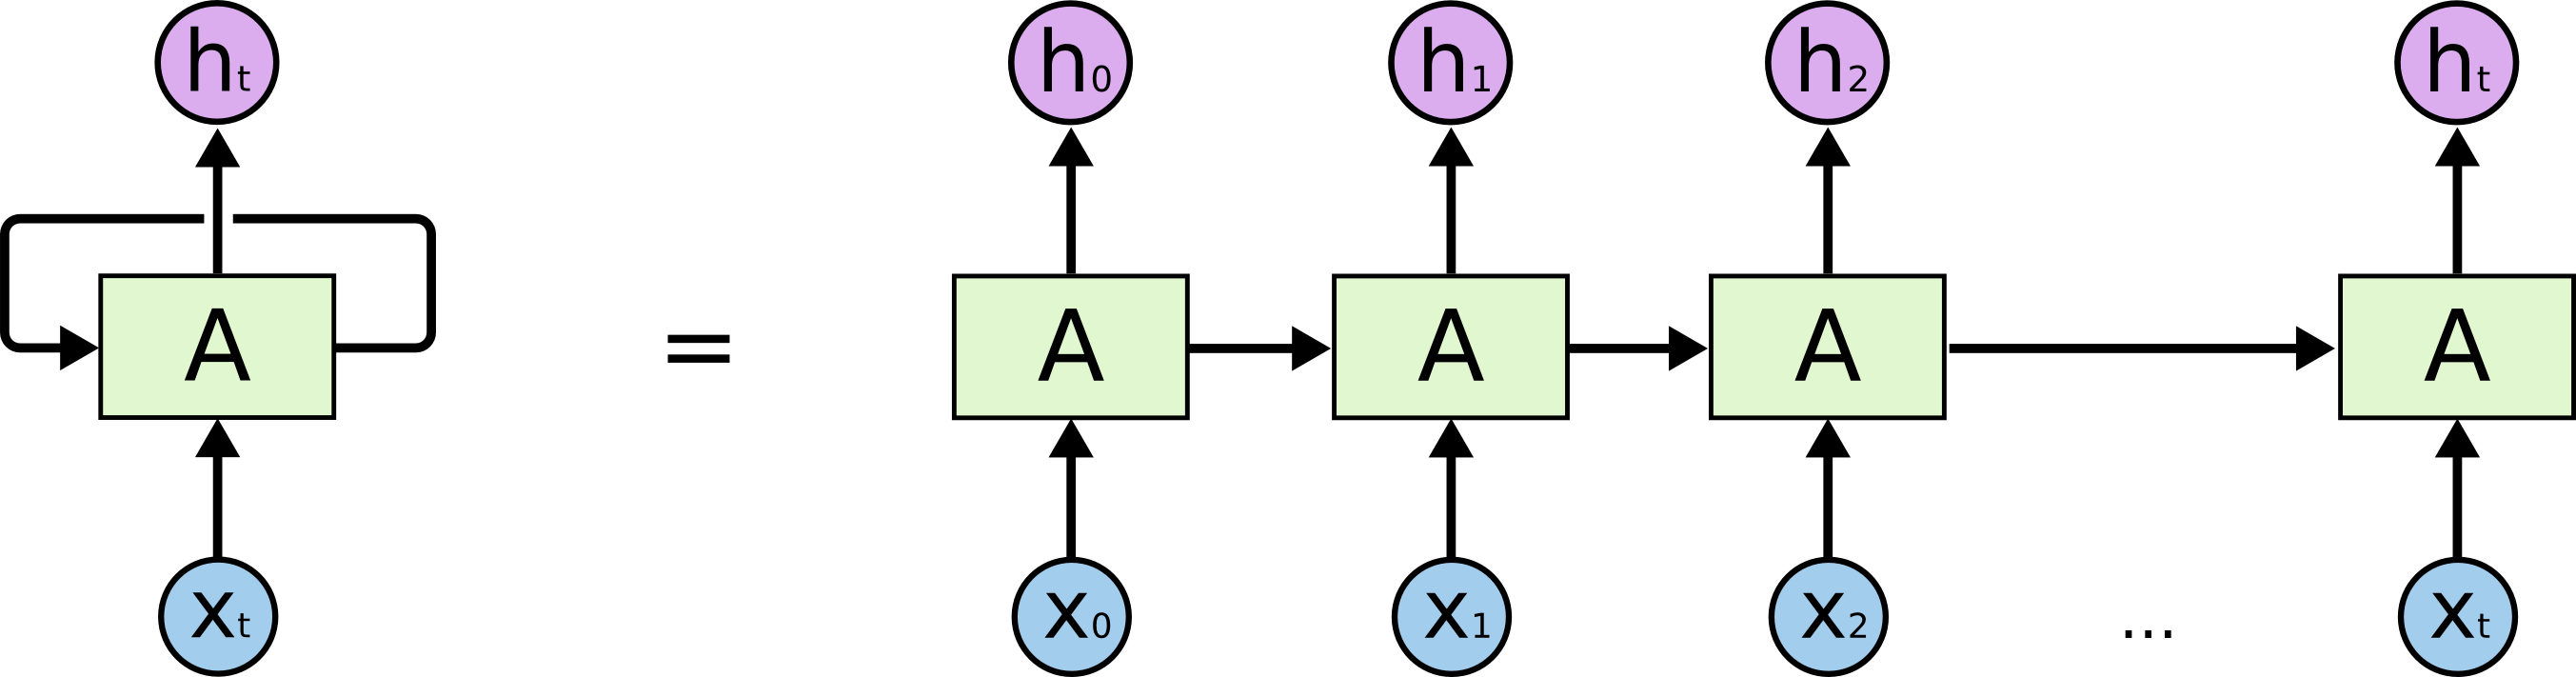


The idea behind the recurrent network is that it creates a kind of memory, which remembers all information about what has been calculated.

The **long-short term memory** comes into place as a hidden layer in the network. It's purpose is to enable RNN to remember inputs over a long period of time. The LSTM network has 3 gates. 
* Input gate, decides what is relevant to add from the current step.
* Forget gate, decides what is relevant to keep from prior steps and deletes information if it isn't important.
* Output gate, determines what the next hidden state should be.

With the above gates the model output the information to the next node & layer using Sigmoid and tanh layers.

In [15]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = hist['Weighted_Price'].values.reshape(-1,1)
print(values[0])
# Converting the values to float.
values = values.astype('float32')
# Transform values to values between 0 and 1.
# This is the type of input LSTM takes.
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1113.4375]
Length of the new datframe : 2001
[[0.05196624]
 [0.04434619]
 [0.03316076]
 [0.03275506]
 [0.03938658]]


In [16]:
# Divide scaled data into 80% train and 40% test with overlapping.
train_size = int(len(scaled) * 0.8)
print("Train Size : " + str(train_size))

test_size = int(len(scaled) * 0.6)
print("Test Size : " + str(len(scaled) - test_size))

train, test = scaled[:train_size,:], scaled[test_size:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1600
Test Size : 801
Length of training data : 1600
Length of testing data : 801


In [17]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# Calling the create_dataset function with loop_back=1.
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1599, 1)
(1599,)
(800, 1)
(800,)


In [19]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1599, 1, 1)
(800, 1, 1)


In [20]:
# Initialise the sequential model
model = Sequential()

# Add the LSTM hidden layer with 128 nodes
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))

# Adding a dropout layer of 0.2 to prevent overfitting.
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(1))

# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')

# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1599 samples, validate on 800 samples
Epoch 1/300
1599/1599 [==============================] - 1s 520us/step - loss: 0.0803 - val_loss: 0.2651
Epoch 2/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0783 - val_loss: 0.2557
Epoch 3/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0743 - val_loss: 0.2488
Epoch 4/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0696 - val_loss: 0.2330
Epoch 5/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0674 - val_loss: 0.2220
Epoch 6/300
1599/1599 [==============================] - 0s 40us/step - loss: 0.0636 - val_loss: 0.2098
Epoch 7/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0600 - val_lo

1599/1599 [==============================] - 0s 42us/step - loss: 0.0062 - val_loss: 0.0086
Epoch 147/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0054 - val_loss: 0.0089
Epoch 148/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0059 - val_loss: 0.0084
Epoch 149/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0051 - val_loss: 0.0084
Epoch 150/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0050 - val_loss: 0.0089
Epoch 151/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0056 - val_loss: 0.0086
Epoch 152/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0065 - val_loss: 0.0087
Epoch 153/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0066 - val_loss: 0.0094
Epoch 154/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0080 - val_loss: 0.0093
Epoch 155/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 41us/step - loss: 0.0045 - val_loss: 0.0085


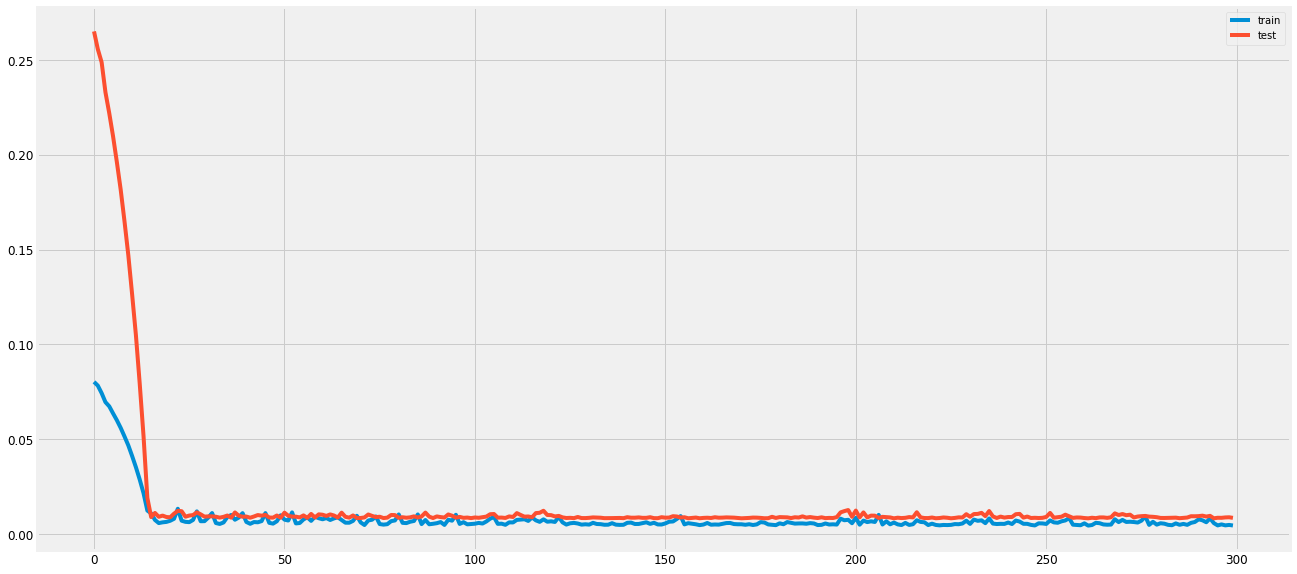

In [21]:
# Plotting the training loss vs the test validation loss.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

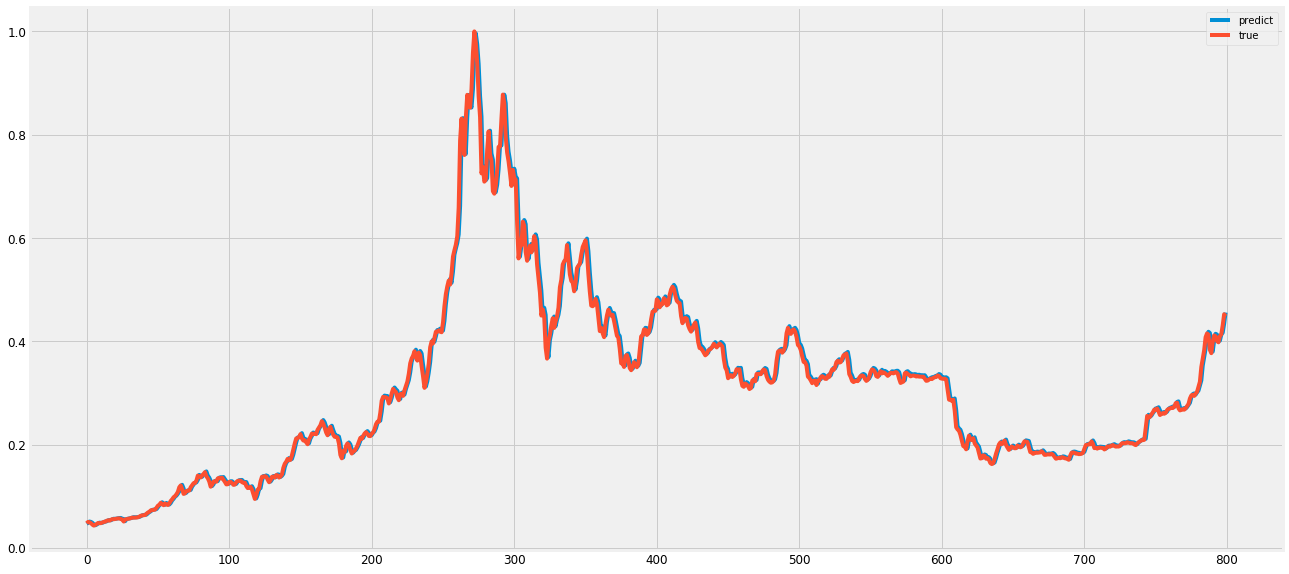

In [22]:
# We predict the values from testX.
yhat = model.predict(testX)

# Plotting the actual graph vs the predicted graph.
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [23]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(800, 1)
(800, 1)
[1019.065]
[1033.165]


In [24]:
# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(testY_inverse, yhat_inverse)
print('Mean absolute error',mae)

Mean absolute error 163.45726


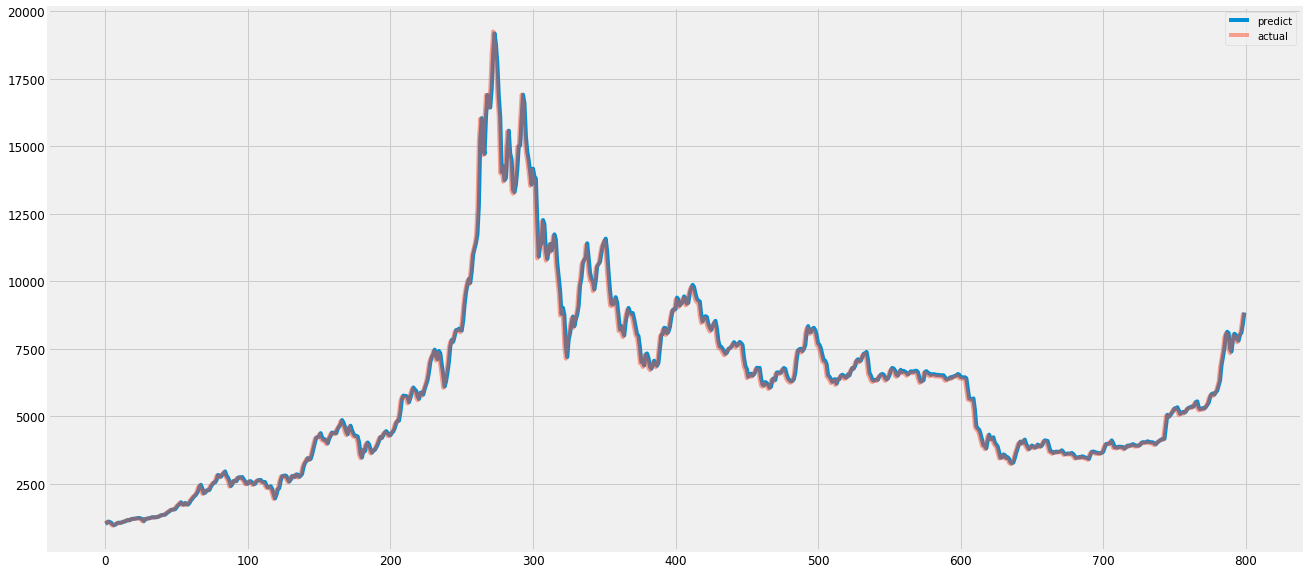

In [25]:
# Plotting prediction vs actual graph.
# This plotting shows the price.
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [33]:
# Creating a new variable containing the testX values.
# Just for good measure.
Xtest = testX

# Predicting the values from Xtest and appending the last preicted value
# to the set before predicting again
for i in range(30):
    future_preds = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    
    y = np.zeros((1,1,1))
    y[[0]] = future_preds[len(future_preds)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)

In [34]:
future_preds_inverse = scaler.inverse_transform(future_preds.reshape(-1, 1))

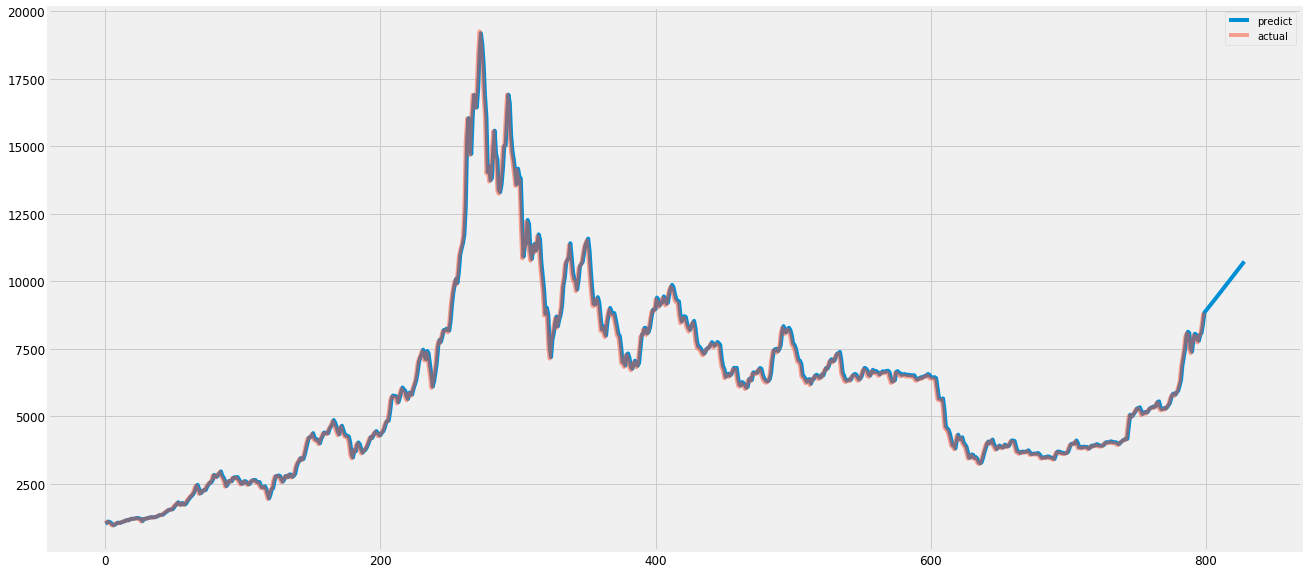

In [67]:
plt.plot(future_preds_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)

plt.legend()
plt.show()

# Refferences
* https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/ (28/05/2019)
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/ (28/05/2019)
* https://towardsdatascience.com/recurrent-neural-networks-and-lstm-4b601dd822a5 (28/05/2019)

# Conclusion

By looking at the the plotted predictions compared to the actual values, and by looking at the mean absoluted error (MAE), it is very clear, that the best model on paper is our RNN LSTM model. The MAE of the SARIMA model is significantly higher than the one of the RNN LSTM model.However, the RNN LSTM model seems to have a random behaviour when predicting future values, which suggests the model is overfitted.

With this in mind we will save the SARIMA model for future predictions.

In [9]:
# Saving the model
results.save('SARIMA_btc_pred.pkl')

In [16]:
%%writefile aiwebflask.py

# Import libraries
import numpy as np
from sklearn.externals import joblib
from flask import Flask, request, jsonify, render_template
import pickle

# create an instance (our app)
app = Flask(__name__)

results = joblib.load('SARIMA_btc_pred.pkl')

@app.route('/', methods=['GET', 'POST'])
@app.route('/hi/<name>')
def hello(name = None):
    return render_template('index.html', name=name)
# name is parameter in the template: {{name}}

@app.route('/predict')
def predict():
    return render_template('prediction.html')

@app.route('/predicted', methods=['GET', 'POST'])
def predicted():
    if request.method == 'POST':
        months = int(request.form['months'])
        predicted = results.get_forecast(steps=months).predicted_mean
        
        predicted = predicted[len(predicted)-1]

        return render_template("predicted.html", content=months, prediction=predicted)

@app.route('/bye')
def bye():
    return render_template('bye.html')

if __name__ == '__main__':
    app.run(debug=True)

Overwriting aiwebflask.py


In [17]:
!python aiwebflask.py

 * Serving Flask app "aiwebflask" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 127-720-728
127.0.0.1 - - [28/May/2019 22:33:11] "GET /predict HTTP/1.1" 200 -
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
127.0.0.1 - - [28/May/2019 22:33:14] "POST /predicted HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2019 22:33:33] "GET /predict?submit=make+another+prediction HTTP/1.1" 200 -
^C


TypeError: unsupported operand type(s) for +: 'datetime.datetime' and 'int'